In [1]:
import glob
import os
import os.path as osp
from pprint import pprint
from typing import Tuple, Any

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from notebook_lib import *
from tablebench.models.compat import DOMAIN_ROBUSTNESS_MODEL_NAMES,\
    SKLEARN_MODEL_NAMES, BASELINE_MODEL_NAMES, DOMAIN_GENERALIZATION_MODEL_NAMES

/Users/jpgard/opt/miniconda3/envs/tableshift/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
baseline_results_dir = '../domain_shift_results'
tableshift_results_dir = '../ray_train_results'
img_dir = "./img"
FIGSIZE=(4,4)

In [4]:
dfs = read_tableshift_results(tableshift_results_dir, baseline_results_dir)
all_results = pd.concat(dfs)



[WARNING] missing results file for expt physionet_los47 model ft_transformer matching ../ray_train_results/physionet/*/*.csv; skipping
[WARNING] missing results file for expt physionet_los47 model resnet matching ../ray_train_results/physionet/*/*.csv; skipping


In [41]:
metric = 'validation_accuracy'
df = best_results_by_metric(all_results, metric=metric)

df['delta_acc_test'] = df['ood_test_accuracy'] - df['id_test_accuracy']

start_len = len(df)

# Add a 'domain generalization' column to df
tasks_meta = pd.DataFrame([(e.taskname_short, e.domain_generalization) for e in EXPERIMENTS_LIST],
            columns=['task', 'domain_generalization'])
df = pd.merge(df, tasks_meta, how='inner', on='task')
assert len(df) == start_len
tasks_meta = tasks_meta.set_index('task')
# task_df.set_index('task', inplace=True)

In [42]:
tasks = sorted(df.task.unique())
estimators = sorted(df.estimator.unique())
print(f"tasks: {tasks}")
print(f"estimators: {estimators}")

tasks: ['acsfoodstamps', 'acsincome', 'acspubcov', 'acsunemployment', 'anes', 'brfss_blood_pressure', 'brfss_diabetes', 'diabetes', 'heloc', 'mimic_extract_hosp_mort', 'mimic_extract_los_3', 'nhanes_lead', 'physionet_los47']
estimators: ['dann', 'deepcoral', 'ft_transformer', 'group_dro', 'irm', 'lightgbm', 'mixup', 'mlp', 'mmd', 'resnet', 'vrex', 'xgb']


In [43]:
import scipy
import math


def clopper_pearson(acc, n, alpha=0.05):
    """Estimate the confidence interval for a sampled Bernoulli random
    variable.
    `x` is the number of successes and `n` is the number trials (x <=
    n). `alpha` is the confidence level (i.e., the true probability is
    inside the confidence interval with probability 1-alpha). The
    function returns a `(low, high)` pair of numbers indicating the
    interval on the probability.
    """
    x = int(acc * n)
    b = scipy.stats.beta.ppf
    lo = b(alpha / 2, x, n - x + 1)
    hi = b(1 - alpha / 2, x + 1, n - x)
    return 0.0 if math.isnan(lo) else lo, 1.0 if math.isnan(hi) else hi


def plot_confidence_interval(ax, xy, x_int, y_int, color='#2187bb', alpha=0.5, width=0.001, **kwargs):
    """Plot a single (x,y) point with (possibly different) confidence intervals for the x- and y-values."""
    x,y = xy
    xmax = max(x_int)
    xmin = min(x_int)
    ymax = max(y_int)
    ymin = min(y_int)
    ax.plot([x,x], y_int, color=color, alpha=alpha) # vertical bars
    ax.plot(x_int, [y,y], color=color, alpha=alpha)  # horizontal bars
    ax.plot([x-width, x+width], [ymax, ymax], color=color, alpha=alpha)  # top CI "tail"
    ax.plot([x-width, x+width], [ymin, ymin], color=color, alpha=alpha)  # bottom CI "tail"
    ax.plot([xmin, xmin], [y-width, y+width], color=color, alpha=alpha)  # left CI "tail"
    ax.plot([xmax, xmax], [y-width, y+width], color=color, alpha=alpha)  # right CI "tail"
    
    ax.plot(x, y, color=color, alpha=alpha, **kwargs)
    return ax

In [44]:
estimator_markers = {
    # baseline
    'xgb': 'v',
    'lightgbm': 'X',
    'mlp': "^", 
    'ft_transformer': "D", 
    'resnet': ">", 
    # domain robustness
    'dro': '$\circ$',    
    'group_dro': '$\clubsuit$', 
    # domain generalization
    'dann': 'P', 
    'irm': '$\spadesuit$', 
    'mixup': '$\heartsuit$', 
    'vrex': "h",
    # domain adaptation
    'mmd': "<", 
    'deepcoral': "*", 
    
}

estimator_titles = {
    # baseline
    'xgb': 'XGBoost',
    'lightgbm': 'LightGBM',
    'mlp': "MLP", 
    'ft_transformer': "FT-Transformer", 
    'resnet': "ResNet", 
    # domain robustness
    'dro': 'DRO',    
    'group_dro': 'Group DRO', 
    # domain generalization
    'dann': 'DANN', 
    'irm': 'IRM', 
    'mixup': 'MixUp', 
    'vrex': "VREX",
    # domain adaptation
    'mmd': "MMD", 
    'deepcoral': "CORAL", 
    
}



In [144]:
_,estimator_type_colors = values_to_colors(pd.Series(['Baseline', 'Domain Robustness',
                                                     'Domain Generalization',
                                                     'Domain Adaptation']))

def get_estimator_color(est):
    if est in ['mmd', 'deepcoral']:
        return estimator_type_colors['Domain Adaptation']
    elif est in DOMAIN_GENERALIZATION_MODEL_NAMES:
        return estimator_type_colors['Domain Generalization']
    elif est in DOMAIN_ROBUSTNESS_MODEL_NAMES:
        return estimator_type_colors['Domain Robustness']
    else:
        return estimator_type_colors['Baseline']

In [46]:
tasks_meta

,domain_generalization
task,
acsfoodstamps,True
acsincome,True
acspubcov,False
acsunemployment,True
anes,True
brfss_diabetes,True
brfss_blood_pressure,False
diabetes,True
heloc,False


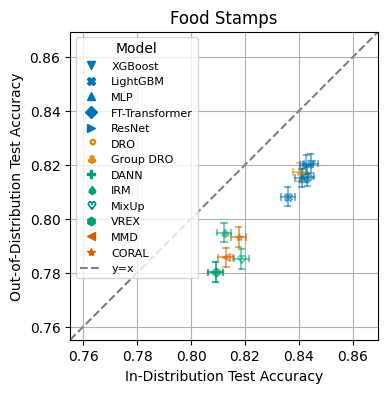

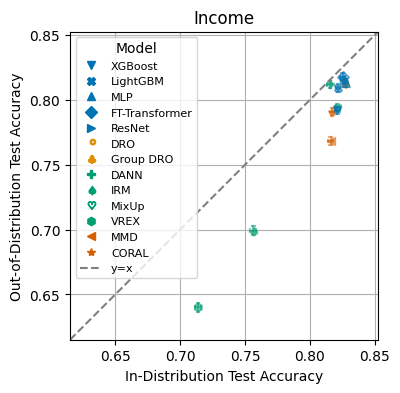

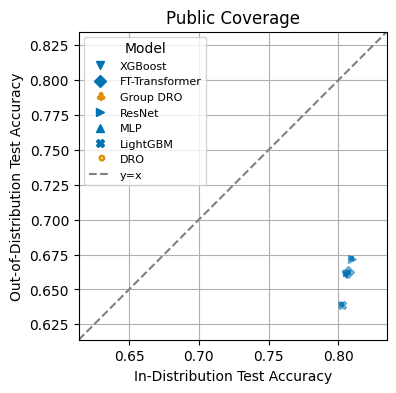

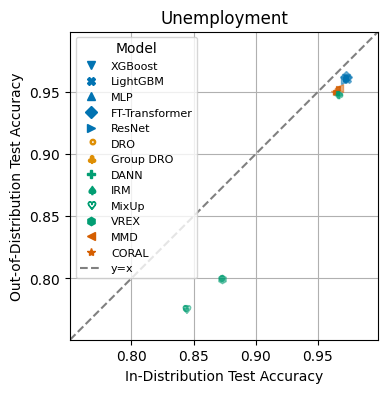

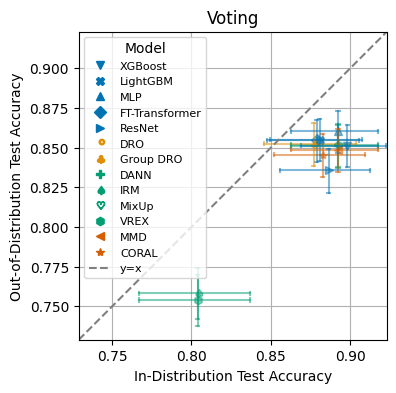

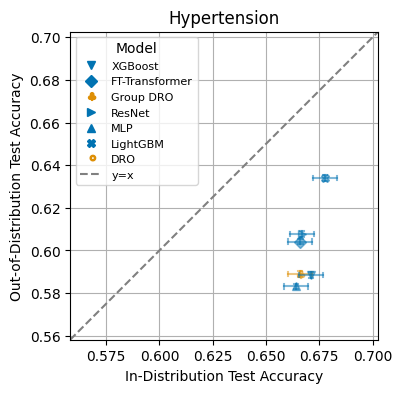

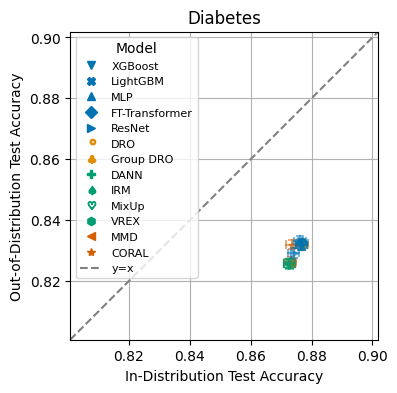

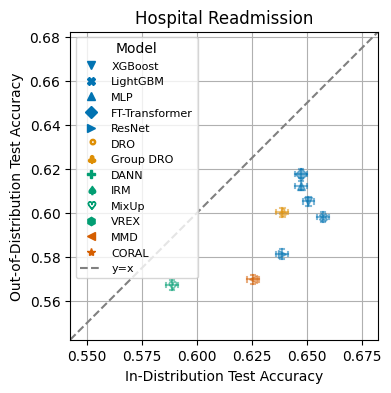

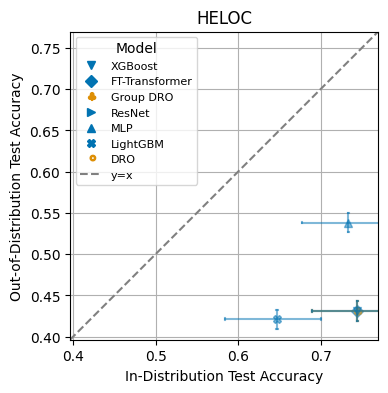

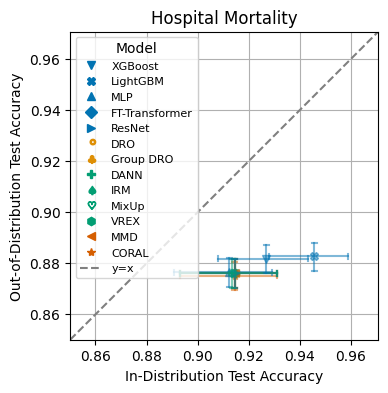

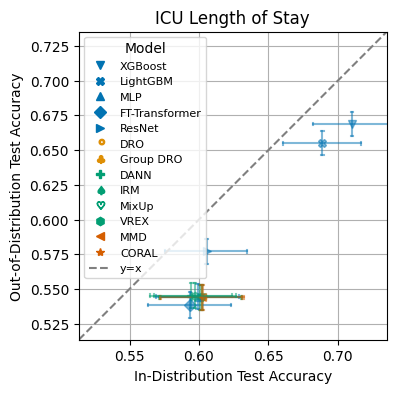

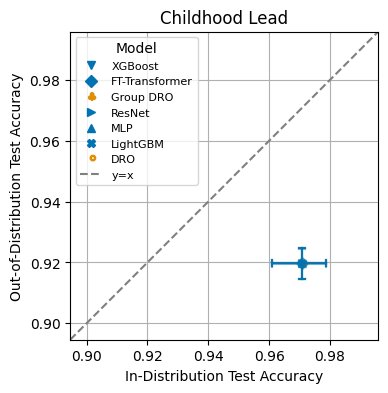

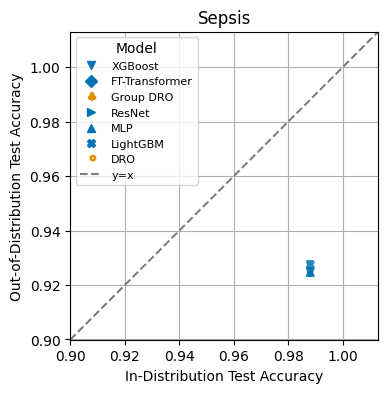

In [47]:
xval = 'id_test_accuracy'
yval = 'ood_test_accuracy'
ood_colname = 'domain_split_ood_values'

axpad = 0.025 # axis margin padding, in data coordinates




tasks_to_title = {x.taskname_short: x.title_name for x in EXPERIMENTS_LIST}

_,estimator_colors = values_to_colors(pd.Series(estimator_markers.keys()))

for task in tasks:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=FIGSIZE)
    ax.set_title(tasks_to_title[task])
    task_df = df.query(f"task == '{task}'")

    
    if not len(task_df):
        print(f"no results for task {task}, skipping")
        continue
    for estimator in task_df.estimator.unique():
        df_ = task_df.query(f"estimator == '{estimator}'")
        assert len(df_) == 1  # check exactly one result per task-model pair
        x,y = df_[xval], df_[yval]
        if np.isnan(x.item()) or np.isnan(y.item()):
            continue
            
        x_int = clopper_pearson(x, n=task_test_set_sizes[task]['id_test'])
        y_int = clopper_pearson(y, n=task_test_set_sizes[task]['ood_test'])
        plot_confidence_interval(ax, (x,y), x_int, y_int, 
                                 color=get_estimator_color(estimator),
                                marker=estimator_markers[estimator])
    
    xymin = np.nanmin(task_df[[xval, yval]].values) - axpad
    xymax = np.nanmax(task_df[[xval, yval]].values) + axpad
    
    ax.set(xlim=(xymin, xymax), ylim=(xymin, xymax), 
           xlabel='In-Distribution Test Accuracy',
          ylabel='Out-of-Distribution Test Accuracy')
    ax.set_aspect('equal')
    
    ax.axline((xymin, xymin), slope=1, color="grey", linestyle='--')

    # Label using proxy artists; see https://stackoverflow.com/a/45141109/5843188
    def _proxy_artist(m, c, ls="none"):
        return plt.plot([],[],marker=m, color=c, ls=ls)[0]

    keys = estimator_markers.keys()
    if tasks_meta.loc[task, 'domain_generalization'] == False:
        keys = list(set(keys) - set(DOMAIN_GENERALIZATION_MODEL_NAMES)) 
    labels = [estimator_titles[e] for e in keys]
    
    handles = [_proxy_artist(estimator_markers[e], 
                         get_estimator_color(e)) 
           for e in keys]
    
    handles.append(_proxy_artist(None, 'grey', '--'))
    labels.append('y=x')

    ax.legend(handles, labels, title='Model', fontsize=8)
    ax.grid()
    plt.savefig(os.path.join(img_dir, f"{task}_scatter.pdf"), bbox_inches='tight')

In [48]:
task_df.groupby('domain_generalization').size()

domain_generalization
False    3
dtype: int64

In [64]:
def flatten_df_columns(df):
    df.columns = ['_'.join(col) for col in df.columns]
    return df

avg_df = df.groupby(['domain_generalization', 'estimator'])[['id_test_accuracy', 'ood_test_accuracy']].agg(
                      {'id_test_accuracy':['mean','std'],
                      'ood_test_accuracy':['mean','std']})
# remove multiindex on columns
avg_df = flatten_df_columns(avg_df)
avg_df

id_test_accuracy_mean  \
domain_generalization estimator                               
False                 ft_transformer               0.797235   
                      group_dro                    0.793791   
                      lightgbm                     0.817239   
                      mlp                          0.839205   
                      resnet                       0.815789   
                      xgb                          0.835979   
True                  dann                         0.837826   
                      deepcoral                    0.838906   
                      ft_transformer               0.805445   
                      group_dro                    0.796696   
                      irm                          0.818131   
                      lightgbm                     0.834998   
                      mixup                        0.794244   
                      mlp                          0.799505   
                      mmd                          0.812873   
                      resnet                       0.820009   
                      vrex                         0.797558   
                      xgb                          0.837638   

                                      id_test_accuracy_std  \
domain_generalization estimator                              
False                 ft_transformer              0.129357   
                      group_dro                   0.158320   
                      lightgbm                    0.159243   
                      mlp                         0.164557   
                      resnet                      0.152147   
                      xgb                         0.139451   
True                  dann                        0.120501   
                      deepcoral                   0.116309   
                      ft_transformer              0.135501   
                      group_dro                   0.124145   
                      irm                         0.119337   
                      lightgbm                    0.112231   
                      mixup                       0.127217   
                      mlp                         0.124554   
                      mmd                         0.132827   
                      resnet                      0.130220   
                      vrex                        0.109585   
                      xgb                         0.108783   

                                      ood_test_accuracy_mean  \
domain_generalization estimator                                
False                 ft_transformer                0.654269   
                      group_dro                     0.646520   
                      lightgbm                      0.708315   
                      mlp                           0.741470   
                      resnet                        0.733126   
                      xgb                           0.704957   
True                  dann                          0.805650   
                      deepcoral                     0.804302   
                      ft_transformer                0.776900   
                      group_dro                     0.762091   
                      irm                           0.778091   
                      lightgbm                      0.800200   
                      mixup                         0.752405   
                      mlp                           0.764838   
                      mmd                           0.771484   
                      resnet                        0.786781   
                      vrex                          0.745894   
                      xgb                           0.801622   

                                      ood_test_accuracy_std  
domain_generalization estimator                              
False                 ft_transformer               0.202370  
                      group_dro                    0.249381  
       

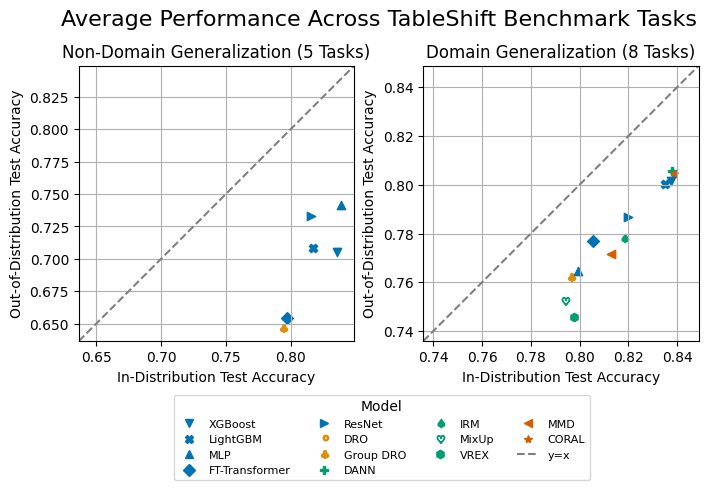

In [50]:
axpad = 0.01

mean_cols = [f"{xval}_mean", f"{yval}_mean"]
std_cols = [f"{xval}_std", f"{yval}_std"]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(FIGSIZE[0]*2, FIGSIZE[1]))

for i,domain_generalization in enumerate((False, True)):
    ax = axs[i]
    dg_df = avg_df.loc[(domain_generalization,), :]
    if domain_generalization:
        title = "Domain Generalization (8 Tasks)"
    else:
        title = "Non-Domain Generalization (5 Tasks)"
    ax.set_title(title)

    for estimator in dg_df.index.unique():
        df_ = dg_df.loc[estimator]

        x = df_[mean_cols[0]]
        y = df_[mean_cols[1]]
        
        se = 1
        x_int = (x - se * df_[std_cols[0]], x + se * df_[std_cols[0]])
        y_int = (y - se * df_[std_cols[1]], y + se * df_[std_cols[1]])

#         plot_confidence_interval(ax, (x,y), x_int, y_int, 
#                                  color=estimator_colors[estimator],
#                                 marker=estimator_markers[estimator])
        ax.scatter(x, y, 
                   color=get_estimator_color(estimator), 
                   marker=estimator_markers[estimator])
    
    xymin = np.nanmin(dg_df[mean_cols].values) - axpad
    xymax = np.nanmax(dg_df[mean_cols].values) + axpad

    ax.set(xlim=(xymin, xymax), ylim=(xymin, xymax), 
           xlabel='In-Distribution Test Accuracy',
          ylabel='Out-of-Distribution Test Accuracy')
    ax.set_aspect('equal')

    ax.axline((xymin, xymin), slope=1, color="grey", linestyle='--')
    ax.grid()
    

    # Label using proxy artists; see https://stackoverflow.com/a/45141109/5843188
def _proxy_artist(m, c, ls="none"):
    return plt.plot([],[],marker=m, color=c, ls=ls)[0]

labels = [estimator_titles[e] for e in estimator_markers.keys()]
    
handles = [_proxy_artist(estimator_markers[e], 
                         get_estimator_color(e)) 
           for e in estimator_markers.keys()]
    
handles.append(_proxy_artist(None, 'grey', '--'))
labels.append('y=x')
    

axs[0].legend(handles, labels, title='Model', fontsize=8,
             bbox_to_anchor=(1.875, -0.175), ncols=4)
plt.suptitle("Average Performance Across TableShift Benchmark Tasks", fontsize=16)
plt.subplots_adjust(wspace=0.25)
plt.savefig(os.path.join(img_dir, "overall_tableshift_scatter.pdf"), bbox_inches='tight')

In [67]:
tmp = df.groupby('estimator')[['delta_acc_test']].agg({'delta_acc_test': ['mean', 'std']})
flatten_df_columns(tmp).sort_values('delta_acc_test_mean')

,delta_acc_test_mean,delta_acc_test_std
estimator,,
xgb,-0.072557,0.079485
ft_transformer,-0.070152,0.088957
group_dro,-0.068405,0.088060
lightgbm,-0.063308,0.061977
mlp,-0.057601,0.049343
vrex,-0.051665,0.016712
resnet,-0.046710,0.034717
mixup,-0.041839,0.015472
mmd,-0.041389,0.014761


In [70]:
!pip install statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 16.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.8/233.8 kB 18.6 MB/s eta 0:00:00


In [78]:
from statsmodels.stats.proportion import proportion_confint
from math import sqrt

def se_delta_acc(row):
    acc_id = row['id_test_accuracy']
    acc_ood = row['ood_test_accuracy']
    
    n_id = task_test_set_sizes[row['task']]['id_test']
    n_ood = task_test_set_sizes[row['task']]['ood_test']
    
    if np.isnan(acc_id) or np.isnan(acc_ood):
        return np.nan
    
    x = int(acc_id * n_id)
    # use method = 'normal' to get symmetric interval
    lower,upper = proportion_confint(x, n_id, method='normal', alpha=0.318)  # set alpha = (1 - 2 * .318) to get 1-sd interval
    sd_id = (upper - lower) / 2.
    
    x = int(acc_ood * n_ood)
    lower,upper = proportion_confint(x, n_ood, method='normal', alpha=0.318)
    sd_ood = (upper - lower) / 2.
    
    # aggregate the SEs
    return sqrt(sd_id**2 + sd_ood**2)
    
df['se_delta_acc'] = df.apply(se_delta_acc, axis=1)

In [92]:
df.domain_generalization

0       True
1       True
2       True
3       True
4       True
       ...  
117    False
118    False
119    False
120    False
121    False
Name: domain_generalization, Length: 122, dtype: bool

In [93]:
delta_acc_mean_and_vars = []  # list of (estimator, mean, variance) tuples

for name,group in df[df.domain_generalization==True].groupby('estimator'):
    valid_results = group.dropna(subset=['delta_acc_test', 'se_delta_acc'])
    if not len(valid_results):
        print(f"no valid results for {name}; skipping")
    delta_acc_mean = group['delta_acc_test'].mean()
    
    sum_of_squared_variances = group['se_delta_acc'].pow(2).sum()
    delta_acc_sd = np.sqrt(sum_of_squared_variances).mean()
    print(name)
    print(f"delta_acc_mean: {delta_acc_mean}, delta_acc_sd: {delta_acc_sd}")
    delta_acc_mean_and_vars.append((name, delta_acc_mean, delta_acc_sd))

dann
delta_acc_mean: -0.032176009147329335, delta_acc_sd: 0.024087845084705614
deepcoral
delta_acc_mean: -0.034604296628276736, delta_acc_sd: 0.0243829658792539
ft_transformer
delta_acc_mean: -0.028544936820526928, delta_acc_sd: 0.022474783805753892
group_dro
delta_acc_mean: -0.03460457426590191, delta_acc_sd: 0.024558899840177326
irm
delta_acc_mean: -0.04003988403069519, delta_acc_sd: 0.026803671674088373
lightgbm
delta_acc_mean: -0.03479826720808048, delta_acc_sd: 0.02327263493887311
mixup
delta_acc_mean: -0.041838763503074125, delta_acc_sd: 0.02415778241573148
mlp
delta_acc_mean: -0.0346668722260598, delta_acc_sd: 0.024103127910813857
mmd
delta_acc_mean: -0.041388994595336945, delta_acc_sd: 0.024143813372722533
resnet
delta_acc_mean: -0.03322743037340109, delta_acc_sd: 0.02434133608665019
vrex
delta_acc_mean: -0.051664596633688956, delta_acc_sd: 0.026863579758770614
xgb
delta_acc_mean: -0.03601598531422848, delta_acc_sd: 0.022934439418367362


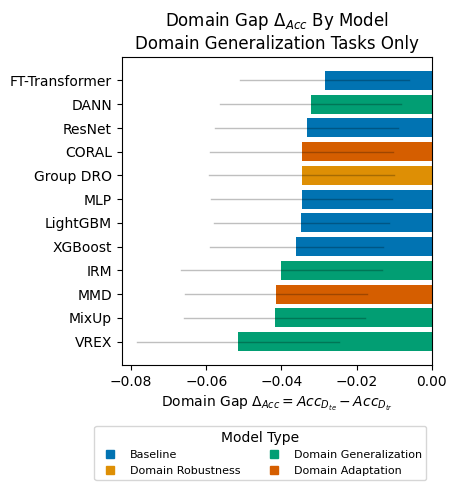

In [159]:
delta_acc_df = pd.DataFrame(delta_acc_mean_and_vars, columns=['estimator', 'delta_acc_mean', 'delta_acc_sd']).sort_values('delta_acc_mean').reset_index()

fig, ax = plt.subplots(1,1,figsize=FIGSIZE)


for i, row in delta_acc_df.iterrows():
    delta_mean, delta_std =  row['delta_acc_mean'], row['delta_acc_sd']
    ax.plot([delta_mean - delta_std, delta_mean+delta_std], [i,i],  color='black', alpha=0.25, linewidth=1) # vertical bars
    est = row['estimator']
    ax.barh(i, delta_mean, color=get_estimator_color(est))
    

keys = estimator_markers.keys()
if tasks_meta.loc[task, 'domain_generalization'] == False:
    keys = list(set(keys) - set(DOMAIN_GENERALIZATION_MODEL_NAMES)) 
labels = estimator_type_colors.keys()

handles = [_proxy_artist("s",  c)  for c in estimator_type_colors.values()]

ax.legend(handles, labels, title='Model Type', fontsize=8,
         bbox_to_anchor=(1, -0.18), ncols=2)
    
ax.set_yticks(delta_acc_df.index.values, [estimator_titles[e] for e in delta_acc_df.estimator])
ax.set_xlabel("Domain Gap $\Delta_{Acc} = Acc_{D_{te}} - Acc_{D_{tr}}$")
_ = ax.set_title("Domain Gap $\Delta_{Acc}$ By Model\nDomain Generalization Tasks Only")
plt.savefig(os.path.join(img_dir, "delta_acc_by_model.pdf"), bbox_inches='tight')

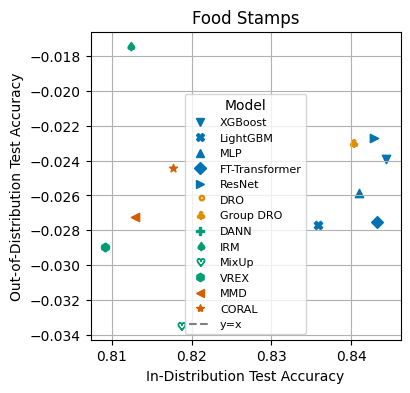

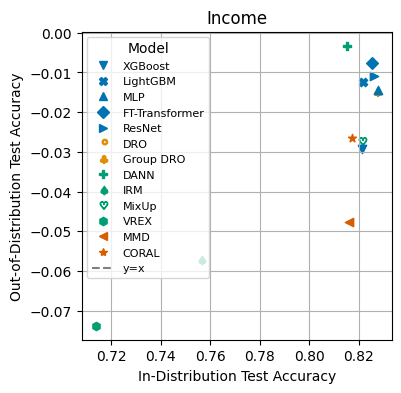

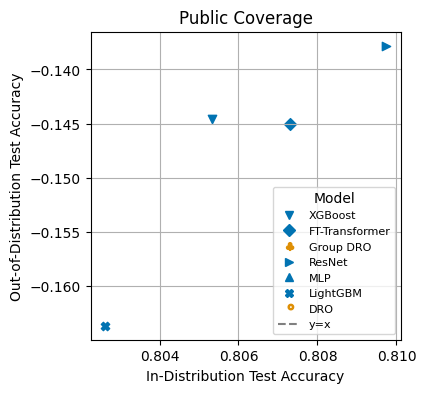

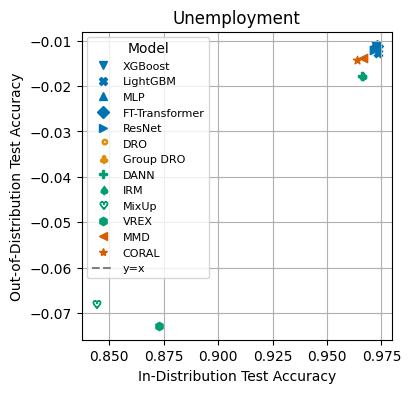

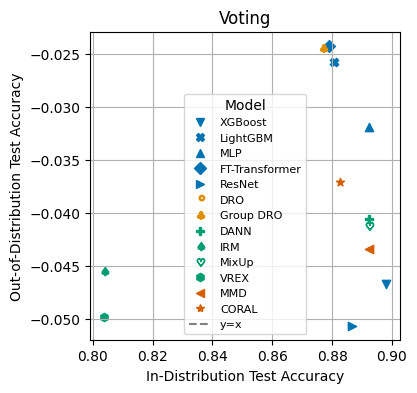

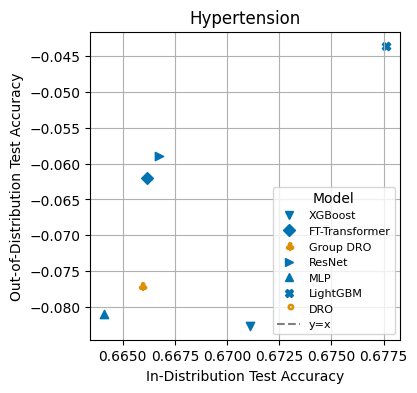

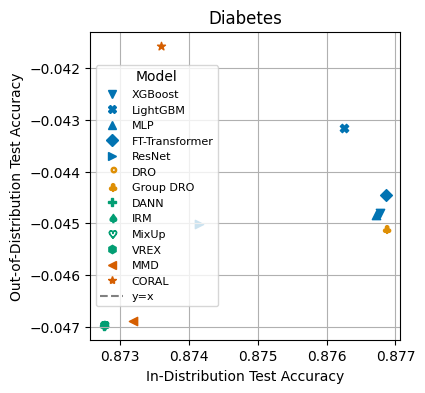

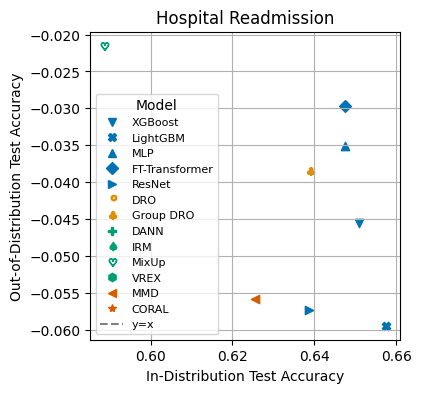

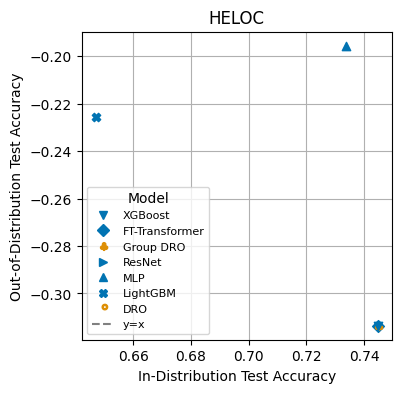

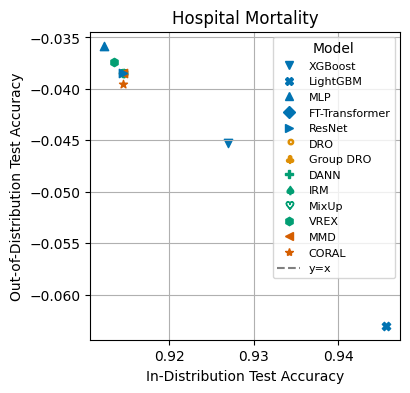

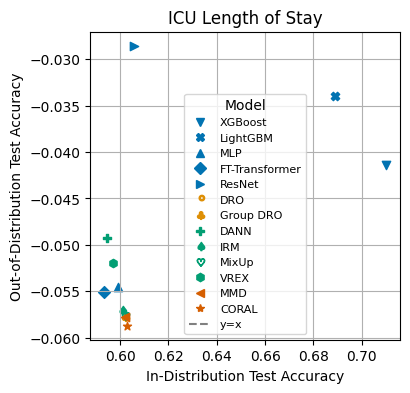

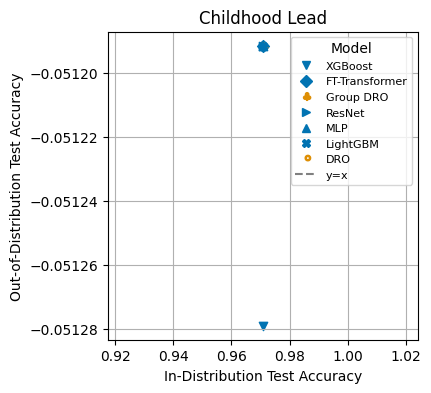

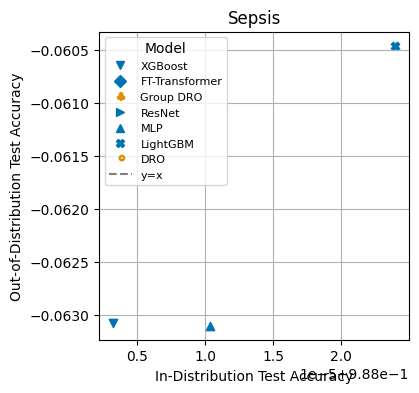

In [57]:
xval = 'id_test_accuracy'
yval = 'delta_acc_test'
ood_colname = 'domain_split_ood_values'

axpad = 0.025 # axis margin padding, in data coordinates




tasks_to_title = {x.taskname_short: x.title_name for x in EXPERIMENTS_LIST}

_,estimator_colors = values_to_colors(pd.Series(estimator_markers.keys()))

for task in tasks:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=FIGSIZE)
    ax.set_title(tasks_to_title[task])
    task_df = df.query(f"task == '{task}'")

    
    if not len(task_df):
        print(f"no results for task {task}, skipping")
        continue
    for estimator in task_df.estimator.unique():
        df_ = task_df.query(f"estimator == '{estimator}'")
        assert len(df_) == 1  # check exactly one result per task-model pair
        x,y = df_[xval], df_[yval]
        if np.isnan(x.item()) or np.isnan(y.item()):
            continue
            
        x_int = clopper_pearson(x, n=task_test_set_sizes[task]['id_test'])
        y_int = clopper_pearson(y, n=task_test_set_sizes[task]['ood_test'])
#         plot_confidence_interval(ax, (x,y), x_int, y_int, 
#                                  color=get_estimator_color(estimator),
#                                 marker=estimator_markers[estimator])
        plt.scatter(x, y, color=get_estimator_color(estimator),
                    marker=estimator_markers[estimator])
    
    xymin = np.nanmin(task_df[[xval, yval]].values) - axpad
    xymax = np.nanmax(task_df[[xval, yval]].values) + axpad
    
    ax.set(xlabel='In-Distribution Test Accuracy',
          ylabel='Out-of-Distribution Test Accuracy')
#     ax.set_aspect('equal')
    
#     ax.axline((xymin, xymin), slope=1, color="grey", linestyle='--')

    # Label using proxy artists; see https://stackoverflow.com/a/45141109/5843188
    def _proxy_artist(m, c, ls="none"):
        return plt.plot([],[],marker=m, color=c, ls=ls)[0]

    keys = estimator_markers.keys()
    if tasks_meta.loc[task, 'domain_generalization'] == False:
        keys = list(set(keys) - set(DOMAIN_GENERALIZATION_MODEL_NAMES)) 
    labels = [estimator_titles[e] for e in keys]
    
    handles = [_proxy_artist(estimator_markers[e], 
                         get_estimator_color(e)) 
           for e in keys]
    
    handles.append(_proxy_artist(None, 'grey', '--'))
    labels.append('y=x')

    ax.legend(handles, labels, title='Model', fontsize=8)
    ax.grid()
#     plt.savefig(os.path.join(img_dir, f"{task}_scatter.pdf"), bbox_inches='tight')